# Step 3
### Cluster Data
<br>

----

#### Load Cities File

In [1]:
import numpy as np
import pandas as pd

In [2]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('../src')))

from make_data_splits import make_data_splits

cities_data = pd.read_pickle("../data/pickles/cities_2.pkl")
make_data_splits(cities_data)


San Francisco
New York City
Paris
Berlin


#### Do Unsupervised Learning on Training Set

In [3]:
from sklearn.covariance import EllipticEnvelope
from sklearn.mixture import BayesianGaussianMixture
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

bgm_pipeline_list = []

for cur_row in cities_data.itertuples():
    print(cur_row.name)
    
    X_train = cur_row.X_train
    X_test = cur_row.X_test
    y_train = cur_row.y_train
    y_test = cur_row.y_test
    
    work_data = cur_row.rentals.copy()

    cluster_indices = y_train.nlargest(
        int(np.ceil(len(y_train) * (20/100)))
    ).index.tolist()

    cluster_data = X_train.loc[cluster_indices].copy()
    cluster_data = pd.merge(
        cluster_data, y_train.loc[cluster_indices], 
        left_index=True, right_index=True
    )

    cluster_data["log_price"] = np.log10(cluster_data.price)
    cluster_data = cluster_data[["longitude","latitude","log_price"]]

    outlier_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('outliers', EllipticEnvelope())
    ])

    cluster_data = cluster_data[outlier_pipeline.fit_predict(cluster_data) == 1]
    cluster_data = cluster_data[["longitude","latitude"]]

    bgm_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('bgm', BayesianGaussianMixture(n_components = 30, n_init = 10, max_iter=800))
    ])

    bgm_pipeline.fit(cluster_data)
    bgm_pipeline_list.append(bgm_pipeline)

    print(list(filter(None,reversed(sorted(np.round(bgm_pipeline.steps[-1][-1].weights_, 2))))))
    print()

cities_data["bgm_pipeline"] = bgm_pipeline_list


San Francisco
[0.34, 0.25, 0.22, 0.19]

New York City
[0.18, 0.17, 0.15, 0.1, 0.09, 0.08, 0.08, 0.06, 0.04, 0.03, 0.01]

Paris
[0.19, 0.15, 0.08, 0.08, 0.07, 0.06, 0.06, 0.05, 0.05, 0.05, 0.04, 0.04, 0.03, 0.03, 0.02, 0.01]

Berlin
[0.23, 0.18, 0.18, 0.15, 0.13, 0.06, 0.05, 0.01]



In [4]:
cities_data.to_pickle("../data/pickles/cities_3.pkl")

#### Make Cost Density Plots

In [5]:
import matplotlib.pyplot as plt 

from plots.make_clusters_plot import make_clusters_plot


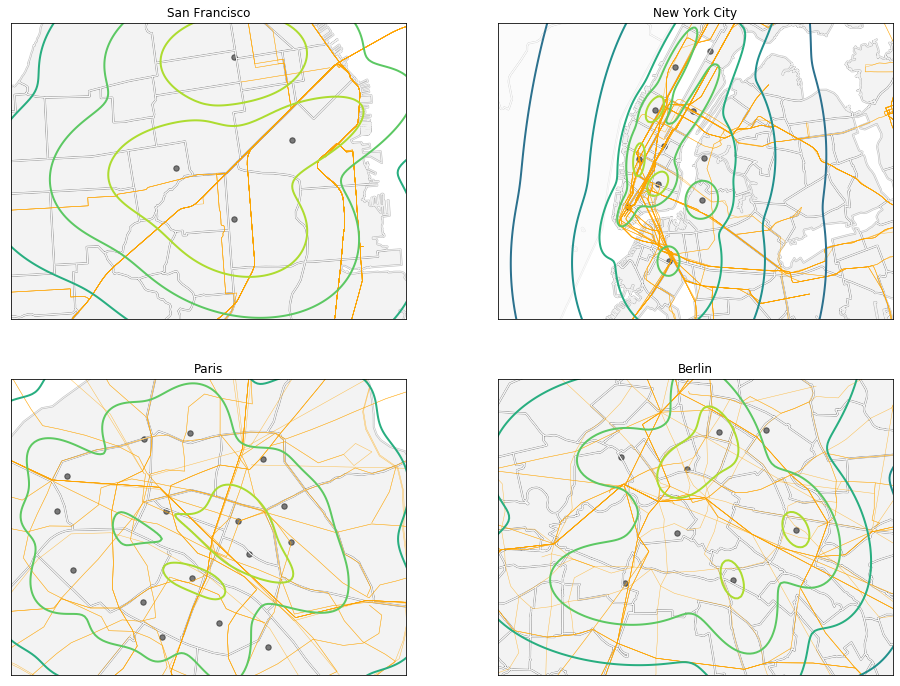

In [6]:
plt.figure(figsize=(16,12))
    
for cur_index, cur_city_data in enumerate(cities_data.itertuples()):
    plt.subplot(2,2,cur_index+1)
    make_clusters_plot(cur_city_data)
